# Setup

In [ ]:
from src.agents.trajectory_constrained_ql_agent_v2 import TrajectoryConstrainedQLV2
from src.agents.succ_feature_ql_agent import SuccessorFeatureQL
from src.agents.safety_feature_ql_agent import SafetyFeatureQL
from src.agents.ql_agent import QL
from src.features.tabular_succ_features import TabularSuccessorFeatures
from src.features.tabular_safety_features import TabularSafetyFeatures
from src.utils import create_dirs, init_logger, read_config, generate_four_rooms, MeanVar, plot_mean_var

In [4]:
# Read configs
training_params = read_config("training.cfg")
env_params = read_config("four_rooms.cfg")
agent_params = read_config("agents.cfg")
feature_params = read_config("features.cfg")

n_trials = training_params["general"]["n_trials"]
n_samples = training_params["general"]["n_samples"]
n_tasks = training_params["general"]["n_tasks"]

All agents share the same initial epsilon, epsilon decay ratio and minimum epsilon. The threshold is set to the same value for constrained RL agents.

# Safety Feature QL vs. Successor Feature QL

Since Safety Feature QL agent is mainly inspired by successor features and generalized policy improvement, Successor Feature QL is chosen as a benchmark. This comparison mainly focuses on whether Safety Feature QL agent can successfully transfer both reward and cost knowledge. A Q Learning agent is also included in this comparison similar to the experiment setup in the Successor Features for Transfer in Reinforcement Learning paper to provide more perspective with regards to the agents' performance.

In [10]:
# Initialize agents
succ_feature_ql = SuccessorFeatureQL(TabularSuccessorFeatures(**feature_params["tabular_sf"]), **agent_params["succ_feat_ql"], **agent_params["agent"])
safe_feature_ql = SafetyFeatureQL(TabularSafetyFeatures(**feature_params["tabular_safety"]), **agent_params["safe_feat_ql"], **agent_params["agent"])
ql = QL(**agent_params["ql"], **agent_params["agent"])

agents = {
    "SuccessorFeatureQL": succ_feature_ql,
    "SafetyFeatureQL": safe_feature_ql,
    "QL": ql,
}

# Initialize performance stats
task_return_hist = [MeanVar() for _ in agents]
task_cost_hist = [MeanVar() for _ in agents]
constrained_agents = {name:a for (name, a) in agents.items() if hasattr(a, "threshold")}
task_constraint_violate_hist = [MeanVar() for _ in constrained_agents]

# Train agents
for trial in range(n_trials):
    print("trial {}".format(trial))
    for name in agents:
        agents[name].initialize()
    for i in range(n_tasks):
        task = generate_four_rooms(env_params["env"]["maze"], i)
        for name in agents:
            agents[name].train_on_task(task, n_samples)
    # Update stats
    for i, name in enumerate(agents):
        task_return_hist[i].update(agents[name].reward_hist)
        task_cost_hist[i].update(agents[name].cost_hist)
    for i, name in enumerate(constrained_agents):
        task_constraint_violate_hist[i].update(constrained_agents[name].violation_hist)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19


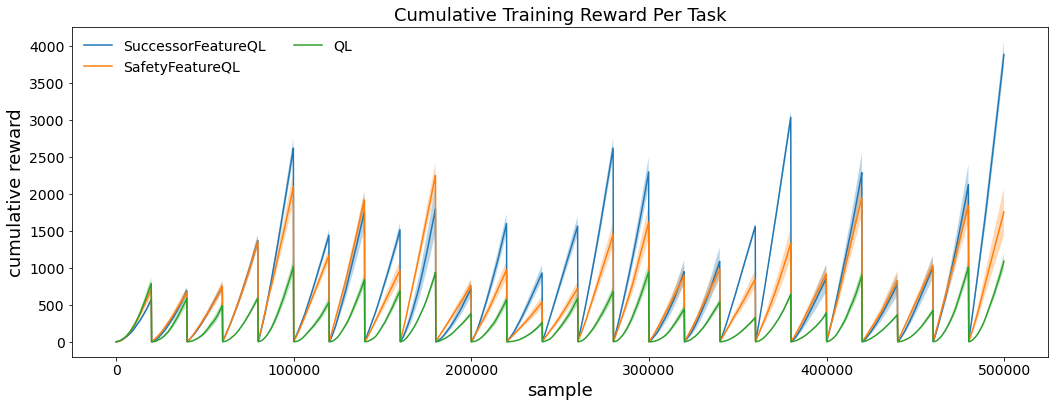

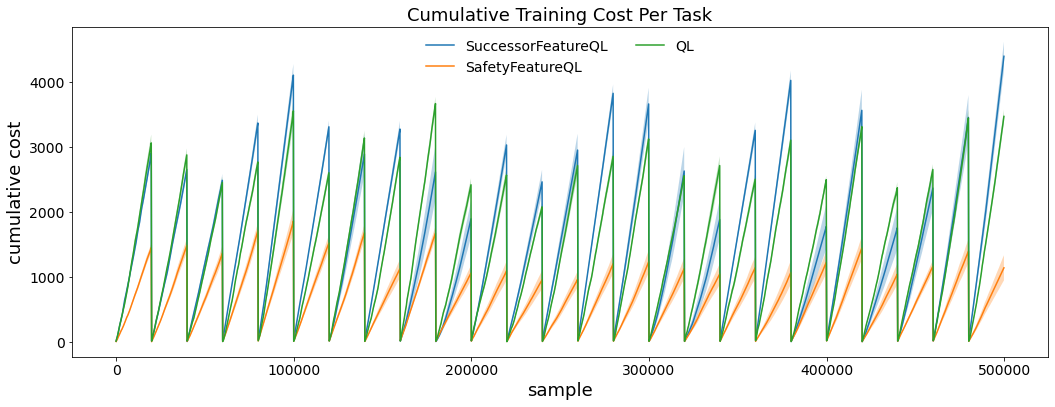

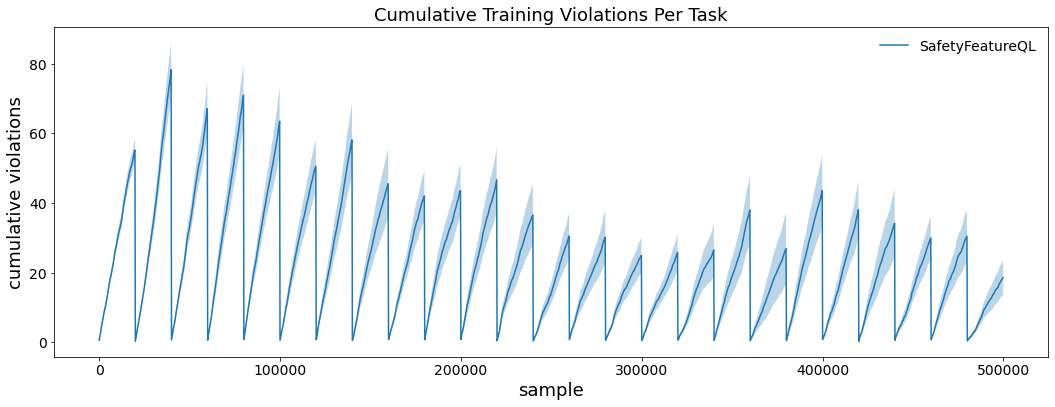

In [9]:
# Plot performance stats
plot_mean_var(task_return_hist, agents.keys(), n_samples, n_tasks, "reward", "return_comparison", save_fig=False, show_fig=True)
plot_mean_var(task_cost_hist, agents.keys(), n_samples, n_tasks, "cost", "cost_comparison", save_fig=False, show_fig=True)
plot_mean_var(task_constraint_violate_hist, constrained_agents.keys(), n_samples, n_tasks, "violations", "violation_comparison",save_fig=False, show_fig=True)

In all plots, each spike represents a new task.

* In the first plot, we can see that the Safety Feature QL agent can match the performance of Successor Feature QL agent for most tasks, and it significantly outperforms the QL agent as more tasks has been trained. We can conclude that the Safety Feature QL agent is able to successfully transfer reward knowledge.

* In the second plot, we can clearly see that the Safety Feature QL agent incurs much less cost during training compared to the unconstrained agents.

* In the third plot, we can observe a downward trend in training constraint violations as the Safety Feature QL agent has been trained on more tasks, this shows the Safety Feature QL agent can successfully transfer cost knowledge.

In conclusion, the Safety Feature QL agent can successfully transfer both reward and cost knowledge, while not losing too much performance in terms of rewards when comparing to Successor Feature QL agent.

# Safety Feature QL vs. Trajectory Constrained QL

Safety Feature QL is also using the key idea behind Trajectory Constrained QL to constrain the agent, hence it is also used as a benchmark here. There are two versions of Trajectory Constrained QL agent in this repository, the first version determines action safety by checking if the immediate cost and the cumulative cost exceeds the threshold, whereas the second version determines action safety by checking if the action cost J(s,a) and cumulative cost exceeds the threshold. The Safety Feature QL agent is based on the second version, which is why the second version is chosen here. The threshold is applied to immediate cost for the Constrained QL agent, hence it is not used here for comparison. 

In [14]:
# Initialize agents
trajectory_constrained_ql_v2 = TrajectoryConstrainedQLV2(**agent_params["trajectory_constrained_ql_v2"], **agent_params["agent"])
safe_feature_ql = SafetyFeatureQL(TabularSafetyFeatures(**feature_params["tabular_safety"]), **agent_params["safe_feat_ql"], **agent_params["agent"])

agents = {
    "TrajectoryConstrainedQL": trajectory_constrained_ql_v2,
    "SafetyFeatureQL": safe_feature_ql,
}

# Initialize performance stats
task_return_hist = [MeanVar() for _ in agents]
task_cost_hist = [MeanVar() for _ in agents]
task_reward_collection_hist = [MeanVar() for _ in agents]

# Train agents
for trial in range(n_trials):
    print("trial {}".format(trial))
    for name in agents:
        agents[name].initialize()
    for i in range(n_tasks):
        task = generate_four_rooms(env_params["env"]["maze"], i)
        for name in agents:
            agents[name].train_on_task(task, n_samples)
    # Update stats
    for i, name in enumerate(agents):
        task_return_hist[i].update(agents[name].reward_hist)
        task_cost_hist[i].update(agents[name].cost_hist)
        task_reward_collection_hist[i].update(agents[name].reward_collection_hist)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19


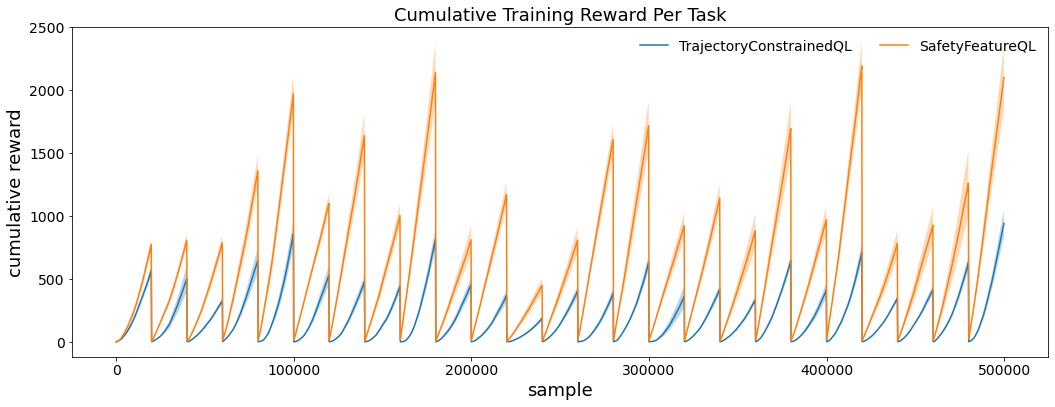

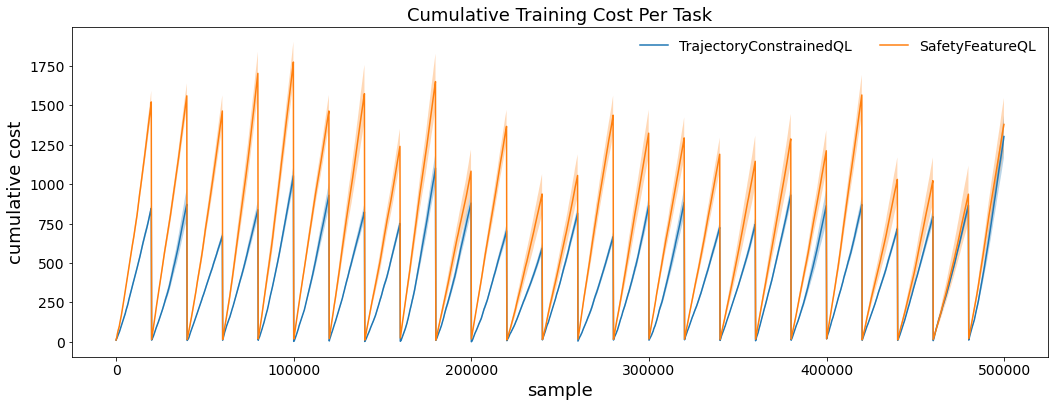

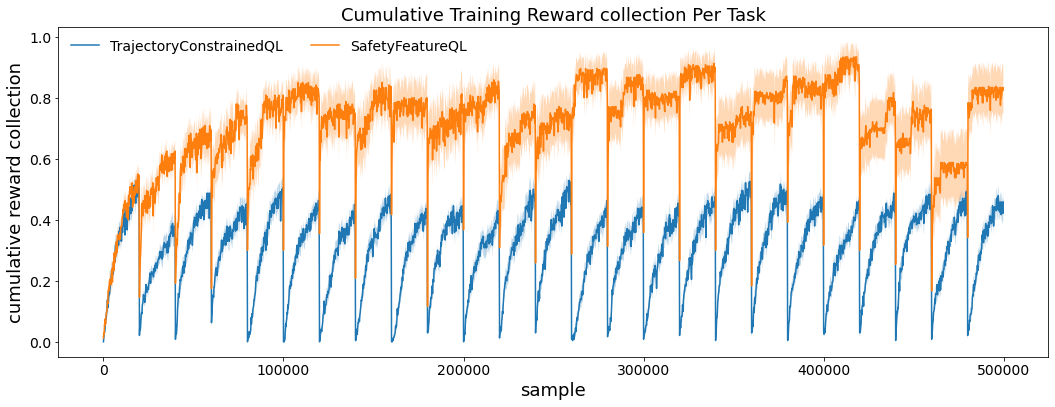

In [7]:
# Plot performance stats
plot_mean_var(task_return_hist, agents.keys(), n_samples, n_tasks, "reward", "return_comparison", save_fig=False, show_fig=True)
plot_mean_var(task_cost_hist, agents.keys(), n_samples, n_tasks, "cost", "cost_comparison", save_fig=False, show_fig=True)
plot_mean_var(task_reward_collection_hist, agents.keys(), n_samples, n_tasks, "reward collection", "reward_collection_comparison", save_fig=False, show_fig=True)

* From the first plot, we can see that the Safety Feature QL agent significantly outperforms the Trajectory Constrained QL agent in terms of rewards.

* In the second and third plot, we can see that Trajectory Constrained QL agent incurrs less training cost than Safety Feature QL agent at the expense of unable to collect all the rewards, which means its policy is not optimal. The third plot also displays the knowledge transfer of reward knowledge for Safety Feature QL agent.